# Linear Regression from scratch

# Import Modules

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

# Generate Dataset

In this step we generate random dataset. We randomly select 500 numbers between 0 and 1 as features. For the dependent variable we add random gaussian noise, with mean 0 and standard deviation of 1. 

In [2]:
def generate_data(size, feature_size=1):
    
    np.random.seed(9)

    # Generate random data points between 0 and 1
    X = np.random.normal(loc = 0, scale=1, size = (size, feature_size))
    # Generate dependent variable by adding random normal noise to X
    y = np.mean(X, axis=1).reshape(-1,1) + np.random.normal(loc=0, scale=0.5, size=(size, 1))
    # Add a new feature with all 1s to account for bias
    X = np.concatenate([X, [[1]]*X.shape[0]], axis =1)
    
    return X, y

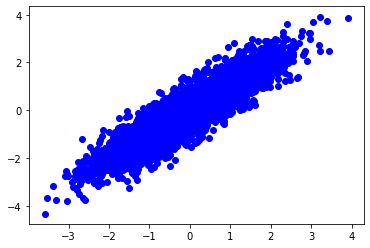

In [3]:
X, y = generate_data(size=5000)
plt.scatter(X[:,0], y, color = "blue")
plt.show()

# Initialize random weights
We assume there is a linear relationship between X and y and hence the best fit line is of the form $y_{pred} = xW+b$, where W,b are the weight and bias values that we need to find in order to find the best fit line and $y_{pred}$ is the predicted value of the dependent variable. In order to do so, we initialize the weights randomly. We include bias term in the weight matrix itself, by a simple modification of the original X, by assuming bias "b" is the the coefficent of the feature whose values are all equal to 1.


Consider a feature matrix X, weight w, bias b
$$ X = \begin{bmatrix} x_{11}  \\ x_{21} \\ x_{31} \end{bmatrix}; W = \begin{bmatrix} w_1 \end{bmatrix}; b = \begin{bmatrix} b_1 \end{bmatrix}$$

The linear regression equation is $y_{pred} =  xW+b$

If X can be modified as $ X_1 = \begin{bmatrix} x_{11} & 1 \\ x_{21} & 1 \\ x_{31} & 1\end{bmatrix}_{Nx2}$; W can be rewritten as $ W_1 = \begin{bmatrix} w_1 \\ b_1 \end{bmatrix}_{2x1}$ and hence, the linear regression equation can be rewritten as $y_{pred} = X_1W_1$.

In [4]:
def initialize_weights(size):
    # Randomly initializing weights 
    w = np.random.normal(size=size)
    return w
W1 = initialize_weights(size=X.shape[1])
W1

array([-1.59694514,  1.78755008])

# The Model

Implementing $y_{pred} = xW_1$ in numpy

In [5]:
def linear_regression_model(X, w):
    y_pred =  np.dot(X, w)
    return y_pred

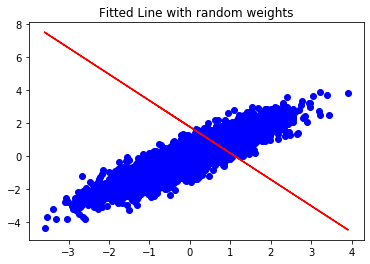

In [6]:
y_pred = linear_regression_model(X, W1)

plt.scatter(X[:,0], y, color= "b")
plt.plot(X[:,0], y_pred, color = "red")
plt.title("Fitted Line with random weights")
plt.show()

# Compute Loss

Clearly, the randomly initialized weight value does not give us the best fit line. Hence, there needs to be a method to find the best weight values optimally, so that the difference between y and $y_{pred}$ is as minimum as possible. In order to measure how much are the predictions off from the actual values, we use mean squared error as the metric. This is the function we would want to minimize by finding the optimal weight values.
$$MSE = \sum\limits_{i=1}^N{(y_{predi}-y_i)^2}/2N$$

In [7]:
def compute_loss(y_true, y_pred):
    return np.mean(np.square(y_pred-y_true))/2

In [8]:
compute_loss(y, y_pred)

3.5335458866324743

# Finding optimal weight values and there by the best fit line optimally.

## Gradient Descent

The algorithm that is used to find the optimal weight values is mini batch stochastic gradient descent.

Steps
1. For each epoch in all epochs:<br>
     - For each mini batch in all mini batches:
         - Calculate the gradient of loss function $\frac{\partial L}{\partial W_1}$  with respect to weights
         The gradient is given by $\frac{\partial L}{\partial W_1} = \frac{X^{T}(XW_1-y)}{N}$
         - Update the weights values in a direction opposite to the gradient. We only make small repetitive updates to the weights. We update the weights with a fraction of the gradient and this fraction is called learning rate(lr). Typical range : (1e-5 to 1e-1)
$$W_{1}  = W_1-lr*\frac{\partial L}{\partial W_1}$$ 
$$W_1 = \begin{bmatrix} w_1 \\ b_1 \end{bmatrix}_{2x1} - lr*\begin{bmatrix} \frac{\partial L}{\partial w_1} \\ \frac{\partial L}{\partial b_1} \end{bmatrix}_{2x1} $$

     - Repeat until the loss does not decrease below a certain threshold.


In [9]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

# Training

In [10]:
def generate_batches(features, target, batch_idx, mini_batch_size):

    batch_X = features[batch_idx*mini_batch_size: (batch_idx+1)*mini_batch_size]
    batch_y = target[batch_idx*mini_batch_size: (batch_idx+1)*mini_batch_size]
    yield batch_X, batch_y

In [11]:
def fit(train_X, train_y, test_X, test_y, epochs,  mini_batch_size, lr,stopping_criteria=1e-6, plot=False):
    model_dict = dict()
    loss_all = []
    weights_all = []
    W1 = initialize_weights(train_X.shape[1])
    for epoch in range(epochs): # for each epoch
        observations = train_X.shape[0]
        iterations = observations//mini_batch_size-1
        iteration=0
        while iteration<=iterations: 
            # for each mini batch
            for batch_X, batch_y in generate_batches(train_X, train_y, iteration, mini_batch_size):
                y_pred = linear_regression_model(batch_X, W1).reshape(-1,1)
                # Calculate Gradient
                dw = (np.dot(batch_X.T, (y_pred-batch_y))/batch_X.shape[0]).reshape(-1,)
                # Update weights
                W1-=lr*dw
                dw=0
            iteration+=1
        
        
        # Collecting weight values
        weights_all.append(W1.copy())
        for phase in ["train", "test"]:  
            if phase == "train":
                train_y_pred = linear_regression_model(train_X, W1).reshape(-1,1)
                train_epoch_loss = compute_loss(train_y, train_y_pred)
            else:
                test_y_pred = linear_regression_model(test_X, W1).reshape(-1,1)
                test_epoch_loss = compute_loss(test_y, test_y_pred)
                
        # Collecting Loss Values
        loss_all.append((train_epoch_loss, test_epoch_loss))
          
    model_dict["loss"] = loss_all
    model_dict["weights"] = W1
    model_dict["all_weights"] = weights_all
    return model_dict

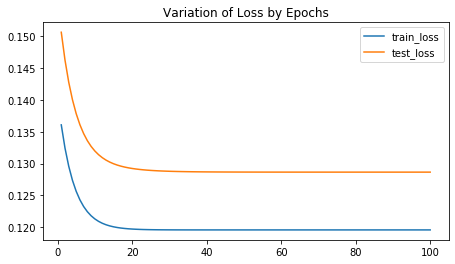

In [12]:
lr=1e-3
mini_batch_size = 32
epochs =100
model = fit(train_X, train_y, test_X, test_y, epochs=epochs, mini_batch_size=32, lr=lr, plot=True)

# Plot the variation of loss by epochs
fig = plt.figure(figsize=(16,4))
fig.add_subplot(1,2,1)
plt.plot(np.arange(1,epochs+1), np.array(model["loss"]))
plt.legend(["train_loss", "test_loss"])
plt.title("Variation of Loss by Epochs")
plt.show()

# Fitted Line

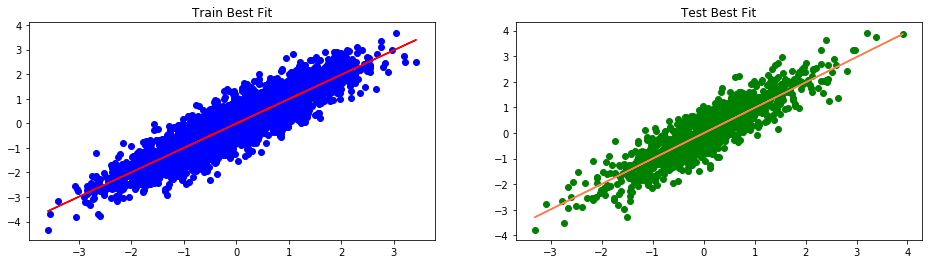

In [13]:
# Print Fit line and loss after every 10 epochs
fig = plt.figure(figsize = (16, 4))
fig.add_subplot(121)
plt.scatter(train_X[:,0], train_y, color="blue")
predictions = linear_regression_model(train_X, model["weights"])
plt.plot(train_X[:,0], predictions, color="red")
plt.title("Train Best Fit")

fig.add_subplot(122)
plt.scatter(test_X[:,0], test_y, color="green")
predictions = linear_regression_model(test_X, model["weights"])

plt.plot(test_X[:,0], predictions, color="coral")
plt.title("Test Best Fit")

plt.show()
  

In [14]:
# !conda install tqdm --y
from tqdm import tqdm

In [15]:
def plot_contours(lr, epochs, batch_size, axis_range):

    
    print("Learning Rate :{}".format(lr))
    model = fit(train_X, train_y, test_X, test_y, 
                epochs=epochs, 
                mini_batch_size=batch_size,
                lr=lr,
                plot=False)

    # Plot the variation of loss by epochs
    fig = plt.figure(figsize=(16,4))
    fig.add_subplot(131)
    plt.plot(np.arange(1,epochs+1), np.array(model["loss"]))
    plt.legend(["train_loss", "test_loss"])
    plt.title("Variation of Loss by Epochs")
    
    
    # Plot Contour Plot to visualize optimization
    fig.add_subplot(132)
    errors = []
    
    # Generate random data points in the range for meshgrid
    X1 = np.linspace(-model["weights"][0]*axis_range[0] , model["weights"][0]*axis_range[0], 100)
    X2 = np.linspace(-model["weights"][1]*axis_range[1],  model["weights"][1]*axis_range[1] , 100)
    all_loss = np.zeros(shape = (X1.shape[0], X2.shape[0]))
    
    
    
    # Compute the loss for each combination 
    for i, value1 in enumerate(X1):
        for j, value2 in enumerate(X2):
            w_temp = np.array((value1,value2))    
            pred = linear_regression_model(train_X, w_temp).reshape(-1,1)
            all_loss[i, j] = compute_loss(train_y, pred)
            errors.append(all_loss[i,j])
            
            
    errors = np.quantile(errors, q=np.arange(0,1.1,0.1))
    
    # Contour Plot
    cp = plt.contour(X2, X1, all_loss, levels=np.unique(errors))
    # Horizontal Line
    plt.axhline(0, color='black', alpha=.5, dashes=[2, 4],linewidth=1)
    
    # Vertical Line
    plt.axvline(0, color='black', alpha=0.5, dashes=[2, 4],linewidth=1)
    plt.title("Loss Contours and optimization path")
    
    # Plot variation in weight per epoch.
    all_weights = np.array(model["all_weights"])
    plt.plot(all_weights[:,1], all_weights[:,0], color="red", marker="*")
    
    # Write the minimum value of loss.
    plt.text(model["weights"][1], model["weights"][0], np.round(model["loss"][-1][0],2))
    plt.clabel(cp, inline=1, fontsize=10)
    plt.xlabel('b')
    plt.ylabel('w1')
    
    fig.add_subplot(133)
    plt.plot(np.arange(1,epochs+1), all_weights[:,0])
    plt.title("Change in weight value by epoch")
    
    plt.show()

# Impact of Learning Rate on training
1. With too high a learning rate makes the model overshoot the local minimum
2. Too low a learning rate might require a greater number of epochs

Learning Rate :5


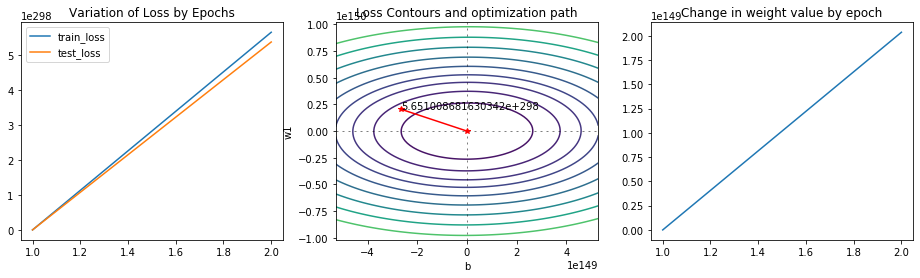

In [16]:
plot_contours(lr=5, epochs=2, batch_size=32, axis_range=(5,2))

Learning Rate :0.1


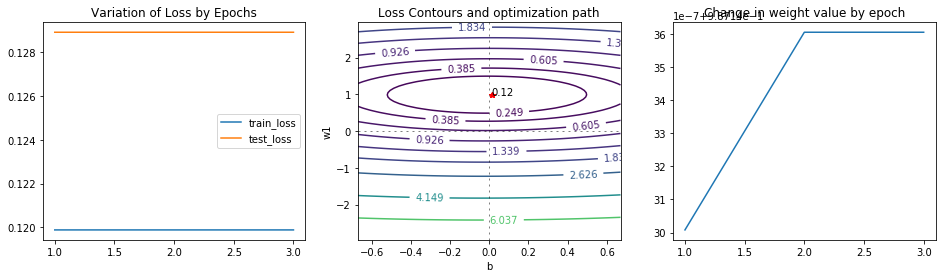

In [17]:
plot_contours(lr=1e-1, epochs=3, batch_size=32, axis_range=(3,50))

Learning Rate :0.01


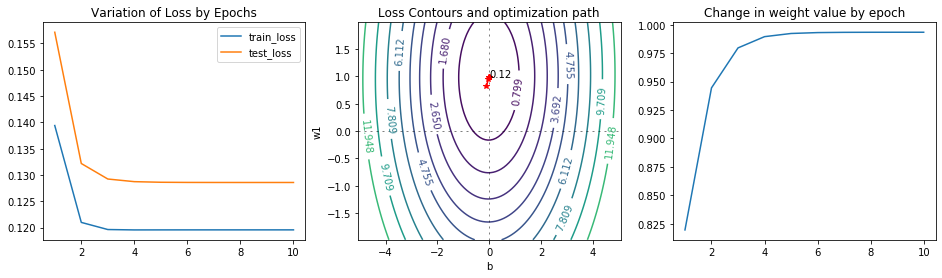

In [18]:
plot_contours(lr=1e-2, epochs=10, batch_size=32, axis_range=(2,1000))

Learning Rate :0.001


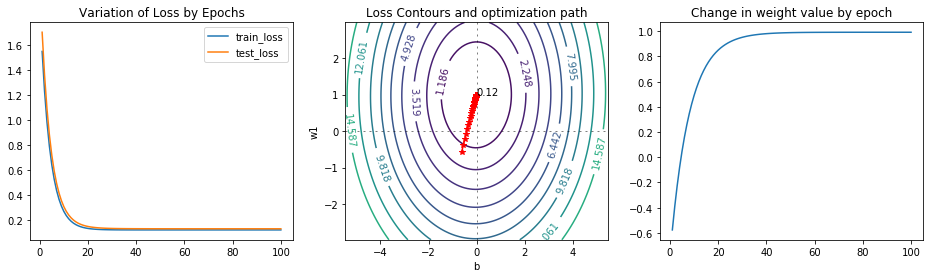

In [19]:
plot_contours(lr=1e-3, epochs=100, batch_size=32, axis_range=(3,500))

Learning Rate :0.0001


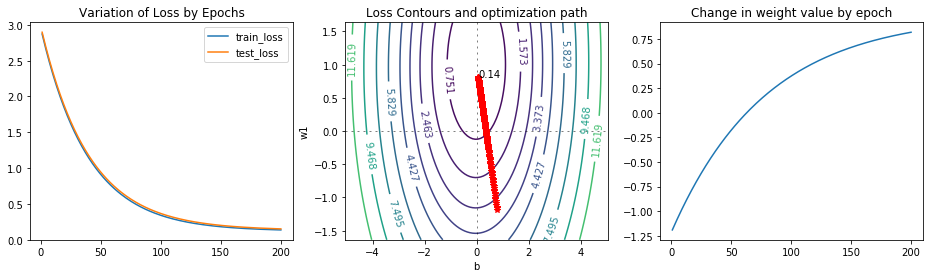

In [20]:
plot_contours(lr=1e-4, epochs=200, batch_size=32, axis_range=(2,100))

# Impact of Batch size on training
1. Lower batch size provides an opportunity to update the weights frequently,hence the model converges earlier as compared to using a larger batch size

Learning Rate :0.001


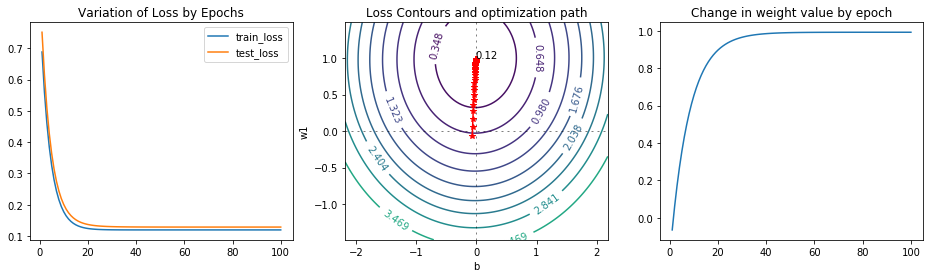

In [21]:
plot_contours(lr=1e-3, epochs=100, batch_size=32, axis_range=(1.5,200))

Learning Rate :0.001


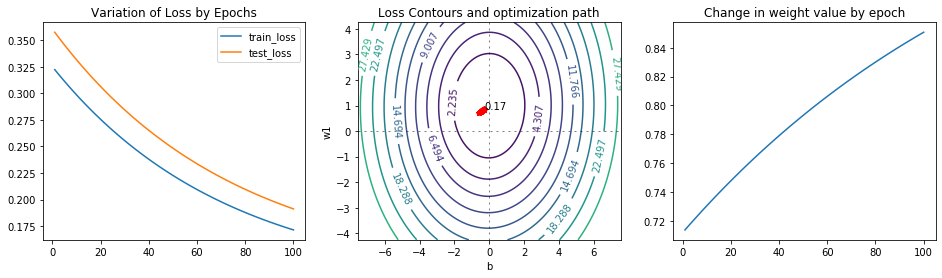

In [22]:
plot_contours(lr=1e-3, epochs=100, batch_size=512, axis_range=(5,25))

Learning Rate :0.001


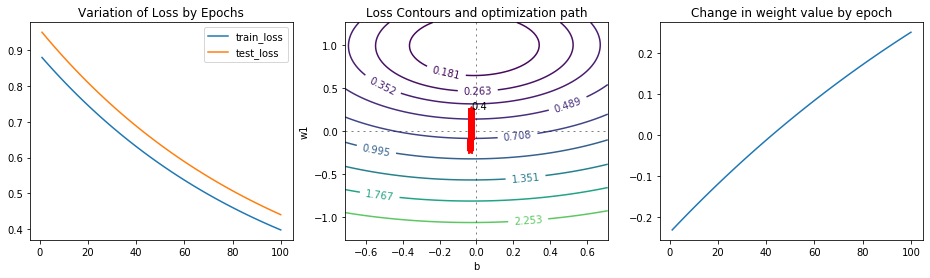

In [23]:
plot_contours(lr=1e-3, epochs=100, batch_size=800, axis_range=(5,25))